<a href="https://colab.research.google.com/github/YosefLab/popV/blob/main/docs/tutorials/notebooks/tabula_sapiens_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Tabula Sapiens as a reference for annotating new datasets

This notebook allows you to annotate your data with a number of annotation methods using the Tabula Sapiens dataset as the reference.

Initial setup:
Using pre-trained models is only supported in python 3.11 due to inconsistencies in pickle. If Google Colab updates their python version, we will also update our pretrained models.


Integration Methods Provided:
- scVI [(Lopez et al. 2018)](https://www.nature.com/articles/s41592-018-0229-2)
- bbKNN [(Polański et al. 2020)](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)
- Scanorama [(He et al. 2019)](https://www.nature.com/articles/s41587-019-0113-3)
- Harmony [(Korsunsky et al. 2019)](https://www.nature.com/articles/s41592-019-0619-0)

Annotation Methods:
- KNN on integrated spaces
- scANVI [(Xu et al. 2021)](https://www.embopress.org/doi/full/10.15252/msb.20209620)
- OnClass [(Wang et al. 2020)](https://www.biorxiv.org/content/10.1101/810234v2)
- Celltypist [(Dominguez Conde et al. 2022)](https://www.science.org/doi/10.1126/science.abl5197)
- SVM
- RandomForest
- XGboost

To use the notebook, simply connect to your Google Drive account, set the necessary arguments, select your methods, and run all the code blocks!

Last edited: 01/23/2025



In [1]:
!pip install -q popv
!pip install numba==0.61.0 # To pickle trained models we need to update numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 1: Setup environment (Restart Notebook after installation)

We omit the output of those lines for readability. First we change the encoding to UTF8 - python default.

In [1]:
import os

os.environ["PYTHONUTF8"] = "1"

In [2]:
%%capture

import pandas as pd
import popv
import scanpy as sc

Instructions for updating:
non-resource variables are not supported in the long term


## Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [3]:
input_file = {
    "source": "cellxgene",
    "path": "tmp/LCA.h5ad",
    "url": "https://cellxgene.cziscience.com/e/8c42cfd0-0b0a-46d5-910c-fc833d83c45e.cxg/",
}
os.makedirs(os.path.dirname(input_file["path"]), exist_ok=True)

if input_file["source"] == "gdrive":
    # OPTION 1: Connect to Google Drive.
    from google.colab import drive

    drive.mount("/content/drive")
    query_adata = sc.read(input_file["path"])
elif input_file["source"] == "cellxgene":
    # OPTION 2: Download from CELLxGENE URL.
    import cellxgene_census

    try:  # CELLxGENE throws error if file exists.
        cellxgene_census.download_source_h5ad(
            dataset_id=input_file["url"].rsplit("/", 2)[1].rsplit(".")[0],
            census_version="stable",
            to_path=input_file["path"],
        )
    except ValueError:
        pass
    query_adata = sc.read_h5ad(input_file["path"])
else:
    query_adata = sc.read(input_file["path"], backup_url=input_file["url"])

query_adata.obs_names_make_unique()
# Downsample to reduce RAM usage. Not necessary with Google Colab Pro.
sc.pp.subsample(query_adata, 0.2)

In [4]:
# CELLxGENE census stores normalized counts in adata.X and raw counts in adata.raw.X. We need raw counts.
query_adata.X = query_adata.raw.X

In [5]:
query_adata.X.data

array([1., 2., 1., ..., 1., 4., 1.], dtype=float32)

## Step 3 (User Action Required): Setting Up Annotation Parameters

Here is where you set the parameters for the automated annotation.

Arguments:
- **huggingface_repo:** Reference model to use. See hugingface for further information (https://huggingface.co/popV).
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction.
- **algorithms:** these are the methods to run. By default, will run all methods provided for the reference data.
Options: ["knn_on_scvi_pred", "scanvi_pred", "knn_on_bbknn_pred", "svm_pred", "rf_pred", "onclass_pred", "knn_on_scanorama_pred".

In [6]:
huggingface_repo = "popV/tabula_sapiens_Lung"
query_batch_key = "donor_id"
algorithms = None

## Step 4: Perform annotation
No more user input required! Just run all the following code blocks.


In [7]:
import numba

numba.__version__

'0.61.0'

### Optional: Train model from scratch.


We provide pretrained models based on Tabula sapiens on huggingface. In case, you want to train popV on your own data this commented code block provides all arguments to do so.

In [ ]:
# from huggingface_hub import snapshot_download

# snapshot_download(repo_id="popV/ontology", repo_type="dataset", local_dir="tmp/ontology")

# cellxgene_census.download_source_h5ad(
#     dataset_id="0d2ee4ac-05ee-40b2-afb6-ebb584caa867",
#     census_version="stable",
#     to_path="tmp/tabula_sapiens_lung.h5ad",
# )

# ref_adata = sc.read("tmp/tabula_sapiens_lung.h5ad")
# ref_adata.X = ref_adata.raw.X # Get count data in CELLxGENE data.

# # popv.settings.cuml = True # Optional to speed up training
# popv.settings.n_jobs = 10

# output_folder = "tmp/annotation_results"
# os.makedirs(output_folder, exist_ok=True)
# ref_labels_key = "cell_type"
# unknown_celltype_label = "unassigned"  # Label of unlabeled cells
# n_samples_per_label = 100 # Downsamples for some classifiers the dataset.

# query_adata.obs['batch_key'] = query_adata.obs.apply(lambda row: row['donor_id'] + '_' + row['assay'] + '_' + row['tissue'], axis=1)
# ref_adata.obs['batch_key'] = ref_adata.obs.apply(lambda row: row['donor_id'] + '_' + row['assay'] + '_' + row['tissue'], axis=1)
# adata = popv.preprocessing.Process_Query(
#     query_adata,
#     ref_adata,
#     query_batch_key="batch_key",
#     ref_labels_key=ref_labels_key,
#     ref_batch_key="batch_key",
#     unknown_celltype_label=unknown_celltype_label,
#     save_path_trained_models=output_folder,
#     cl_obo_folder="tmp/ontology/",
#     prediction_mode="retrain",
#     n_samples_per_label=n_samples_per_label,
#     hvg=4000,
# ).adata

# popv.annotation.annotate_data(
#     adata,
#     save_path=f"{output_folder}/popv_output",
# )

In [10]:
hmo = popv.hub.HubModel.pull_from_huggingface_hub(huggingface_repo, cache_dir="tmp/tabula_sapiens")
adata = hmo.annotate_data(
    query_adata,
    query_batch_key=query_batch_key,
    prediction_mode="inference",  # "fast" does not integrate reference and query.
    # gene_symbols="feature_name", # "Uncomment if using gene symbols."
)

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.50k [00:00<?, ?B/s]

OnClass.meta:   0%|          | 0.00/108k [00:00<?, ?B/s]

OnClass.index:   0%|          | 0.00/222 [00:00<?, ?B/s]

OnClass.npz:   0%|          | 0.00/144M [00:00<?, ?B/s]

celltypist.pkl:   0%|          | 0.00/714k [00:00<?, ?B/s]

accuracies.json:   0%|          | 0.00/6.94k [00:00<?, ?B/s]

OnClass.data-00000-of-00001:   0%|          | 0.00/27.2M [00:00<?, ?B/s]

obo_dag.joblib:   0%|          | 0.00/321k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

harmony_knn_classifier.joblib:   0%|          | 0.00/45.4M [00:00<?, ?B/s]

metadata.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

minified_ref_adata.h5ad:   0%|          | 0.00/94.2M [00:00<?, ?B/s]

predictions.csv:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

preprocessing.json:   0%|          | 0.00/109k [00:00<?, ?B/s]

pynndescent_index.joblib:   0%|          | 0.00/48.2M [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

scvi_knn_classifier.joblib:   0%|          | 0.00/25.6M [00:00<?, ?B/s]

svm_classifier.joblib:   0%|          | 0.00/5.45M [00:00<?, ?B/s]

svm_classifier_cuml.joblib:   0%|          | 0.00/581k [00:00<?, ?B/s]

xgboost_classifier.model:   0%|          | 0.00/8.87M [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

cl.json:   0%|          | 0.00/32.4M [00:00<?, ?B/s]

cl.ontology:   0%|          | 0.00/214k [00:00<?, ?B/s]

cl.ontology.nlp.emb:   0%|          | 0.00/155M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.61k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/33.0 [00:00<?, ?B/s]

cl_popv.json:   0%|          | 0.00/38.1M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.50k [00:00<?, ?B/s]

LLLLLL tmp/tabula_sapiens/models--popV--tabula_sapiens_Lung/snapshots/18b224039714f98bfbdd477ee3d9a40431aacefe ['preprocessing.json', 'harmony_knn_classifier.joblib', 'popv_output', 'metadata.json', 'OnClass.npz', 'xgboost_classifier.model', 'svm_classifier.joblib', 'README.md', 'obo_dag.joblib', 'accuracies.json', 'OnClass.index', 'OnClass.meta', 'OnClass.data-00000-of-00001', 'scanvi', 'checkpoint', '.gitattributes', 'scvi_knn_classifier.joblib', 'celltypist.pkl', 'scvi', 'svm_classifier_cuml.joblib', 'minified_ref_adata.h5ad', 'pynndescent_index.joblib']
INFO     Found 93.60000000000001% reference vars in query data.                                                    


 38%|███▊      | 3/8 [04:43<08:36, 103.26s/it]

INFO     File                                                                                                      
         tmp/tabula_sapiens/models--popV--tabula_sapiens_Lung/snapshots/18b224039714f98bfbdd477ee3d9a40431aacefe/sc
         vi/model.pt already downloaded                                                                            


INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
 50%|█████     | 4/8 [06:17<06:17, 94.49s/it]


UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 2915: ordinal not in range(128)

In [ ]:
# Optional: save the full anndata will all objects
# adata.write(f'{output_folder}/query_and_reference_popv.h5ad')

In [ ]:
# Optional: save the full anndata will all objects
# adata.write(f'{output_folder}/query_and_reference_popv.h5ad')

In [ ]:
list(adata.uns["prediction_keys"])

['popv_celltypist_prediction',
 'popv_knn_bbknn_prediction',
 'popv_knn_harmony_prediction',
 'popv_knn_on_scvi_prediction',
 'popv_onclass_prediction',
 'popv_scanvi_prediction',
 'popv_svm_prediction',
 'popv_xgboost_prediction']

In [ ]:
cell_types = pd.unique(adata.obs[list(adata.uns["prediction_keys_seen"]) + ["cell_type"]].values.ravel("K"))
palette = sc.plotting.palettes.default_102
celltype_colors = dict(zip(list(cell_types), palette, strict=False))

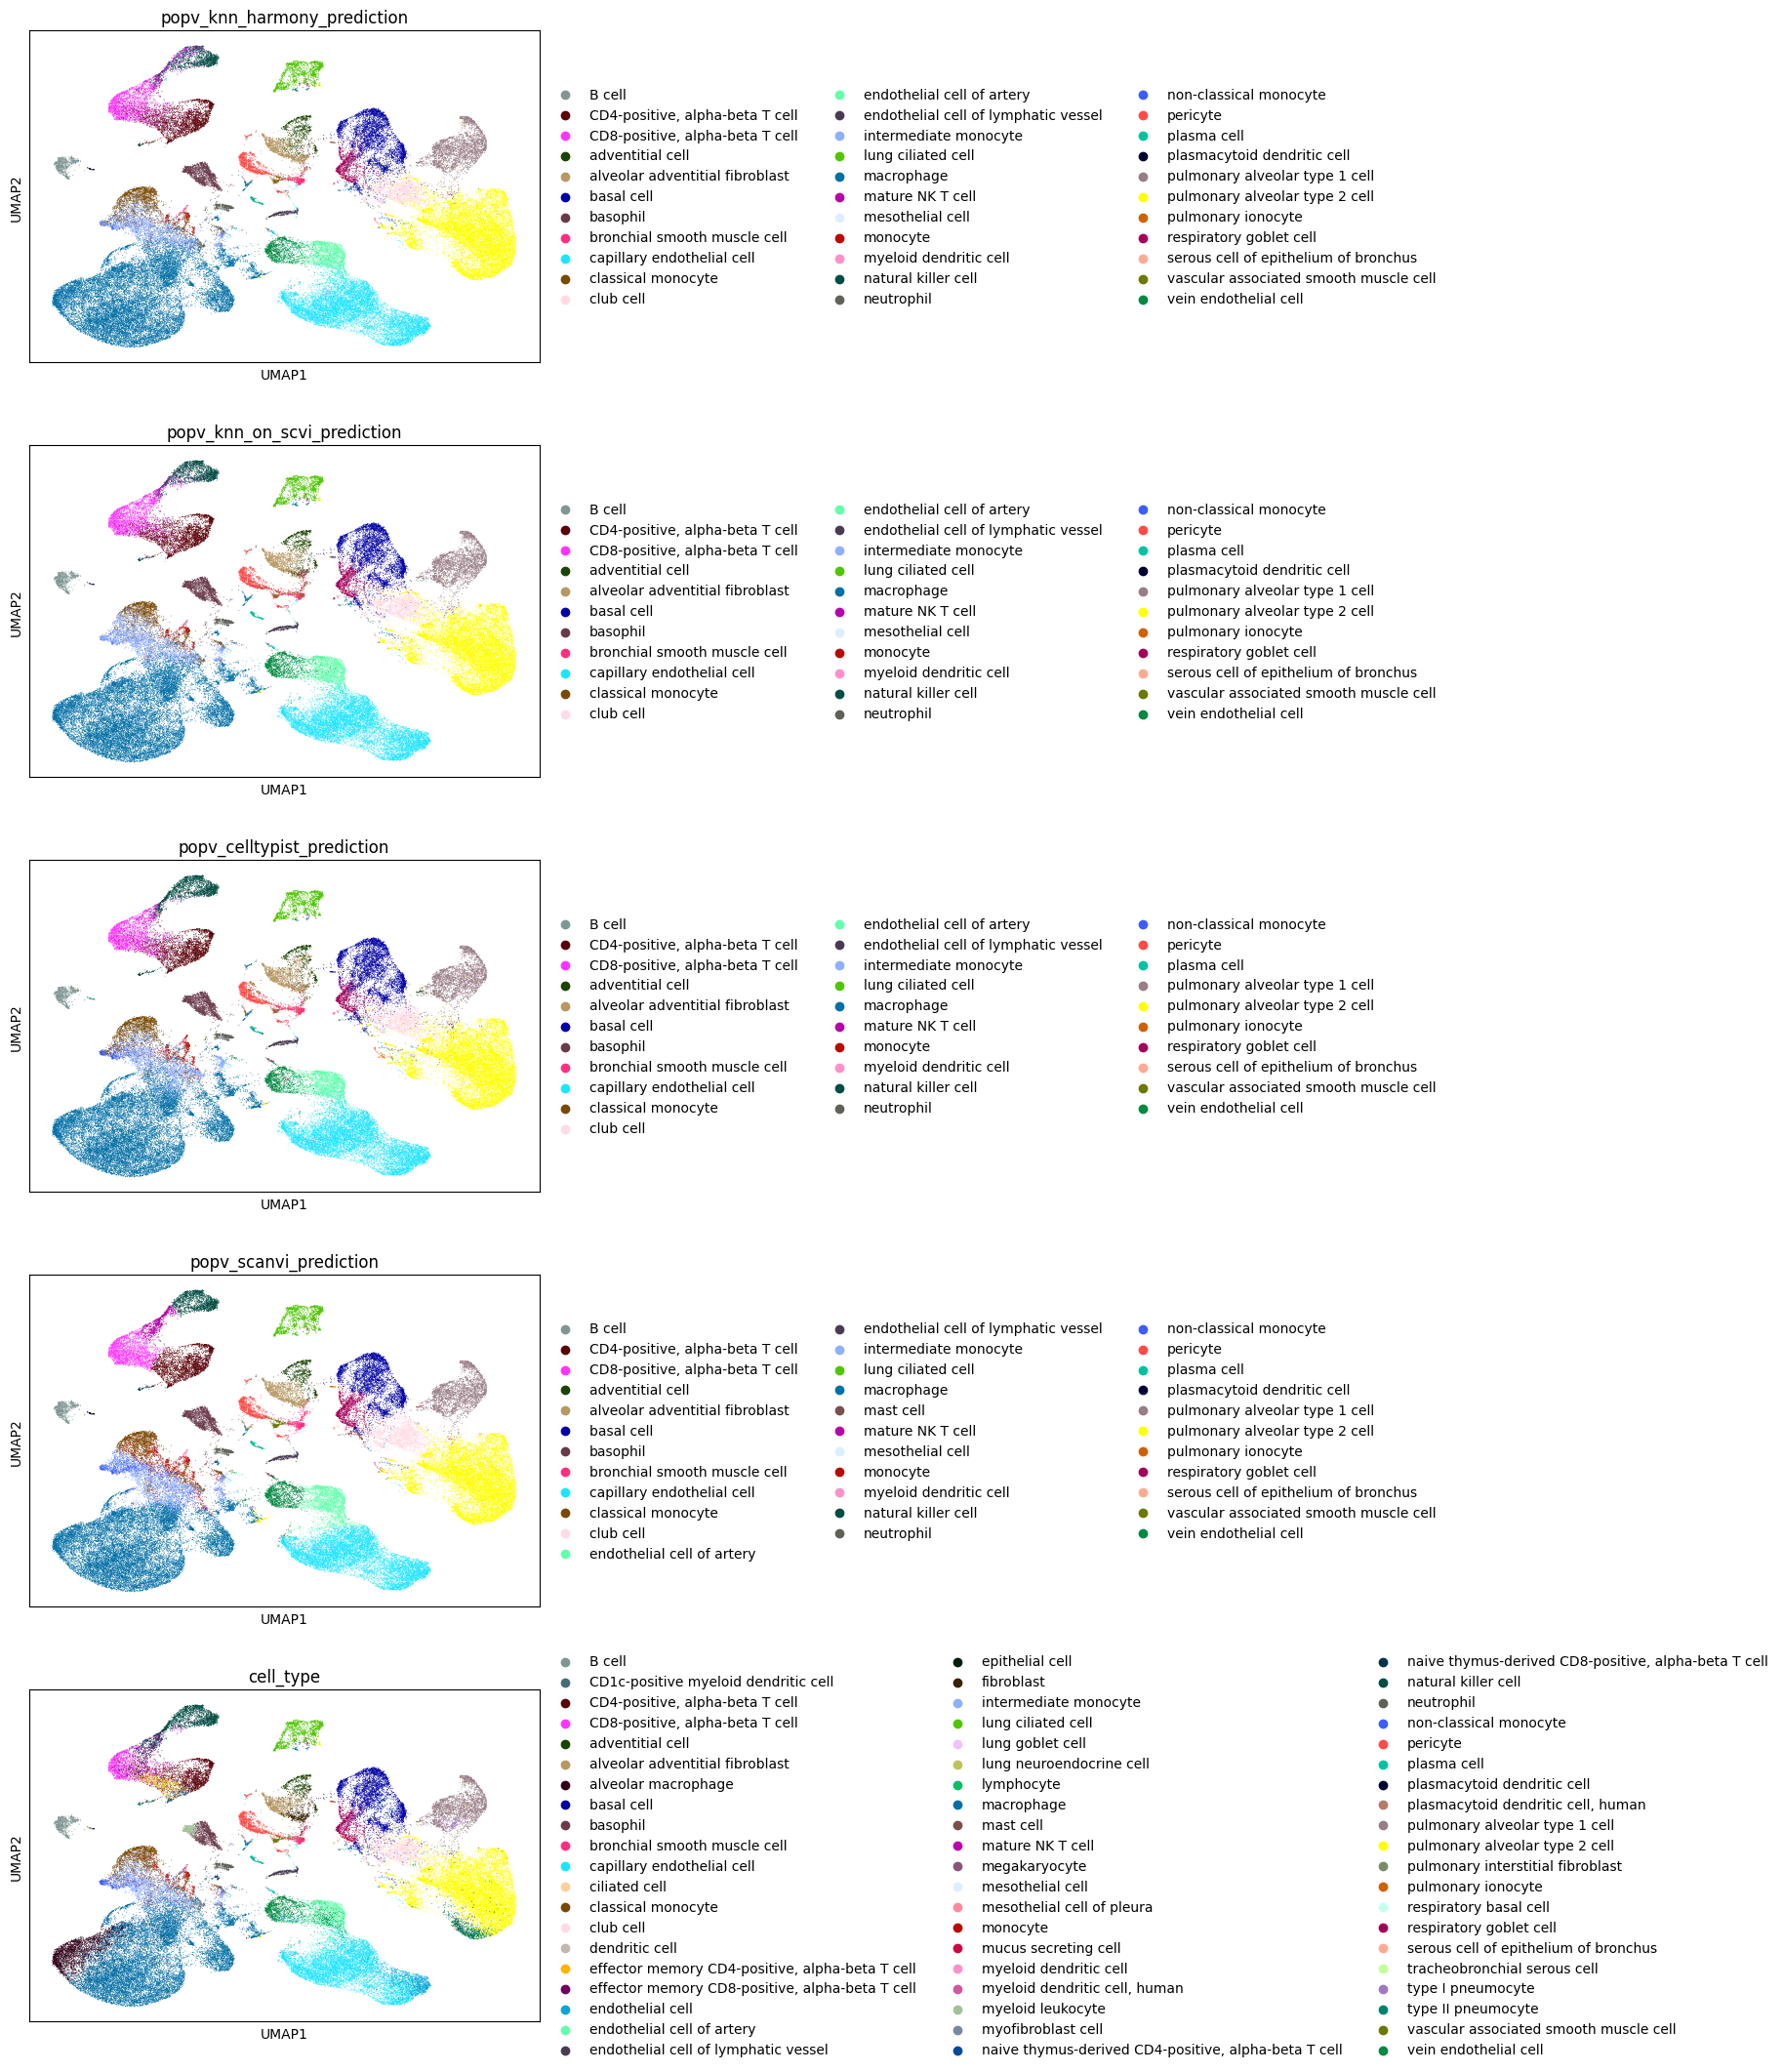

In [ ]:
adata.obsm["X_umap"] = adata.obsm["X_umap_scanvi_popv"]

sc.pl.umap(
    adata,
    color=[
        "popv_knn_harmony_prediction",
        "popv_knn_on_scvi_prediction",
        "popv_celltypist_prediction",
        "popv_scanvi_prediction",
        "cell_type",
    ],
    palette=celltype_colors,
    ncols=1,
)

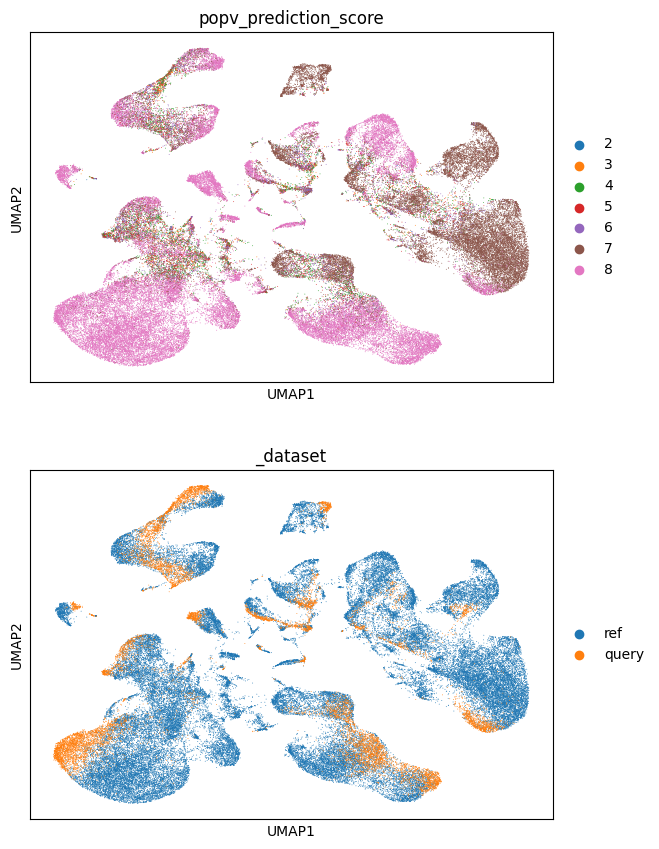

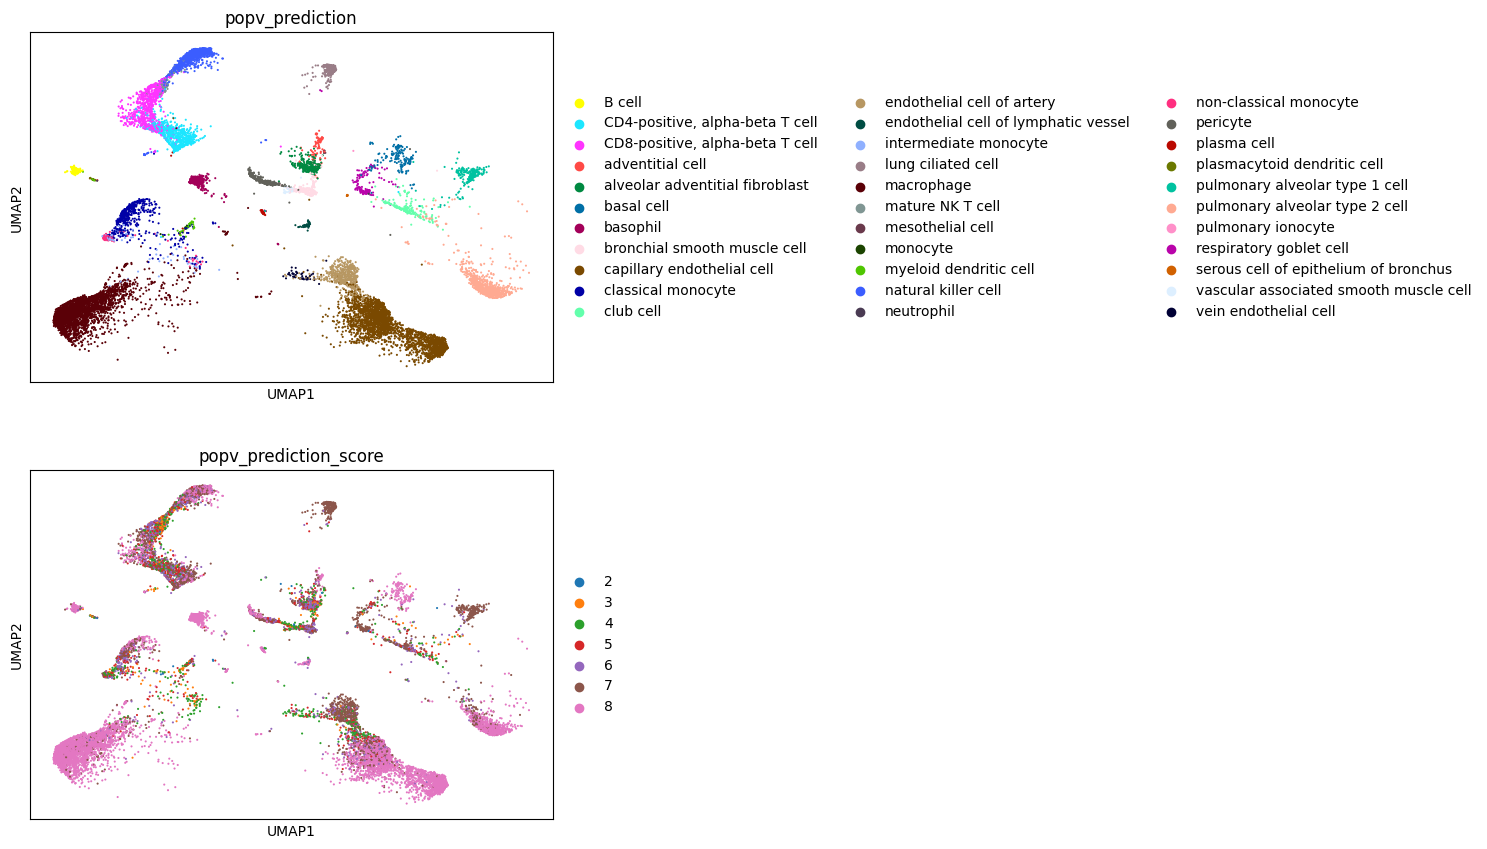

In [ ]:
sc.pl.umap(
    adata,
    color=["popv_prediction_score", "_dataset"],
    ncols=1,
)

sc.pl.umap(
    adata[adata.obs["_dataset"] == "query"],
    color=[
        "popv_prediction",
        "popv_prediction_score",
    ],
    ncols=1,
)

## Step 6: Summary Statistics

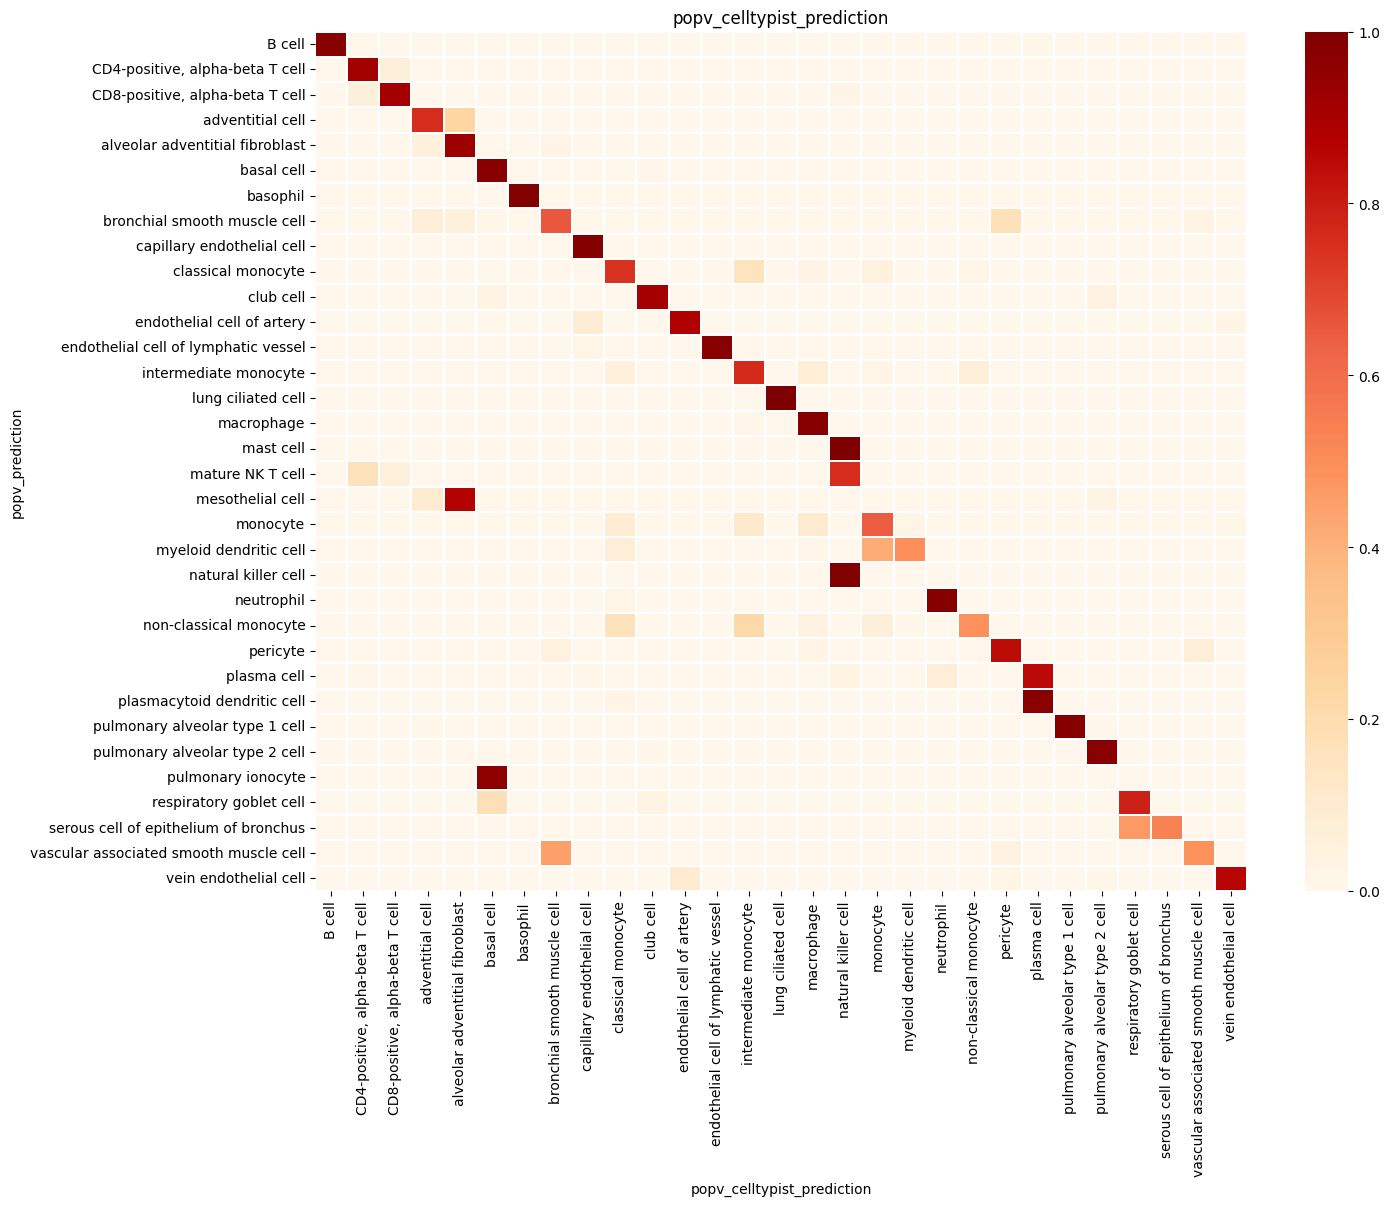

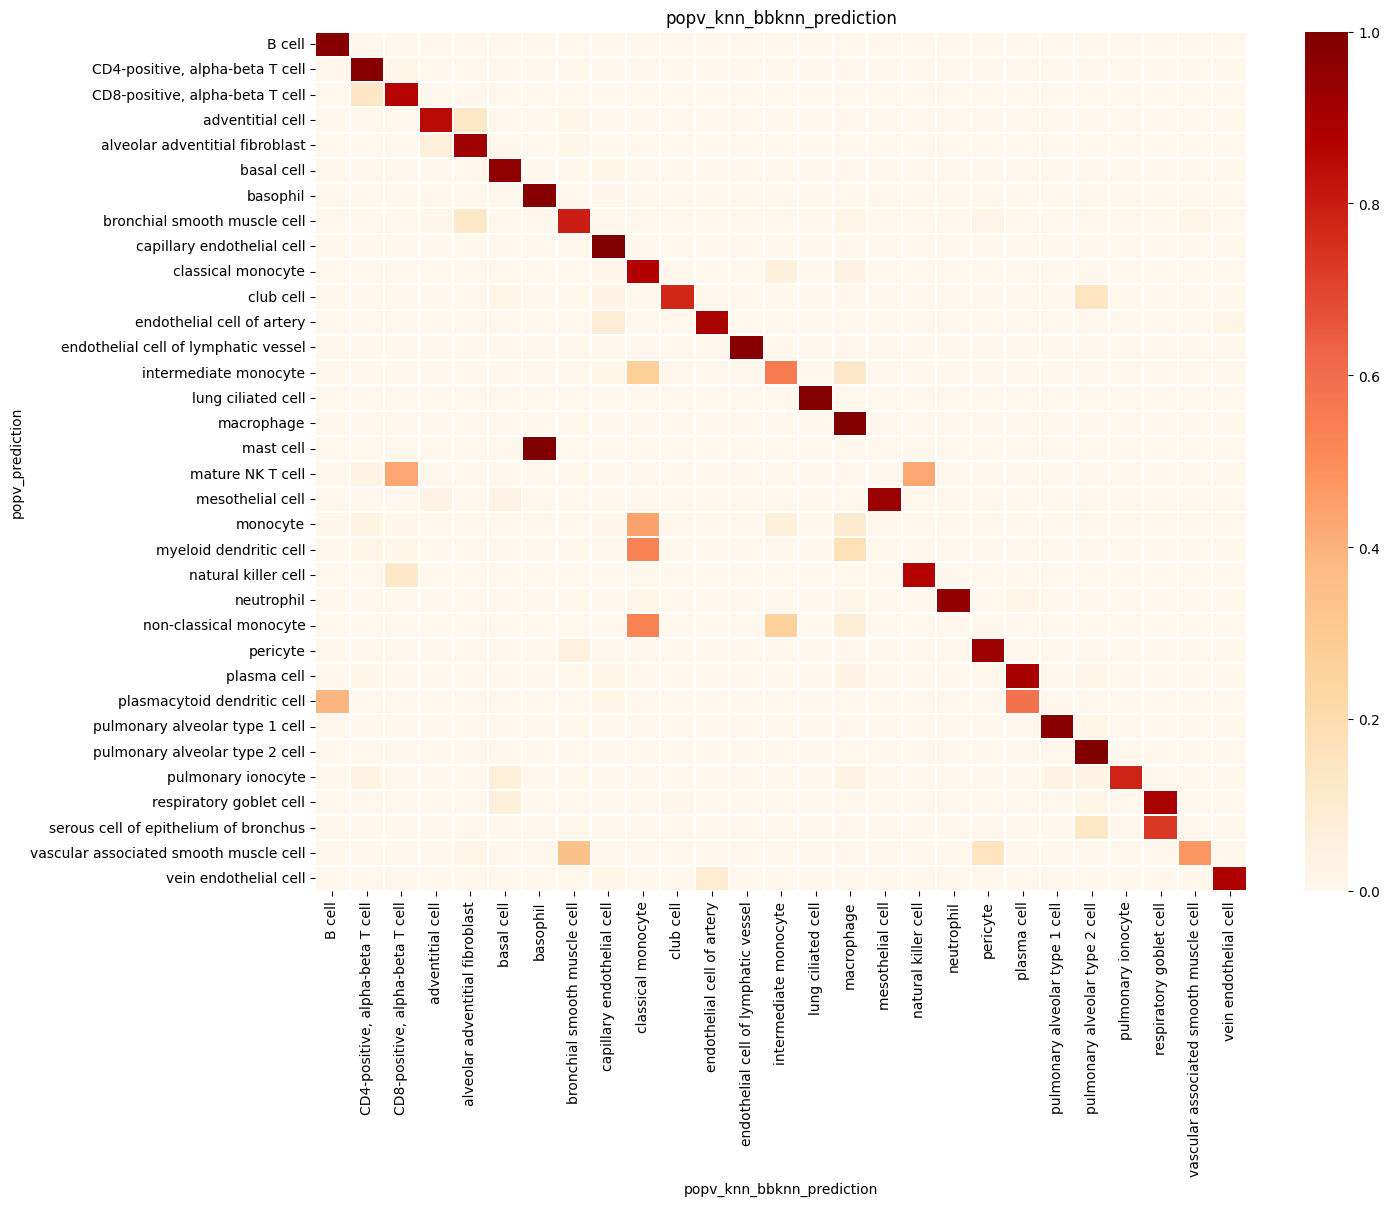

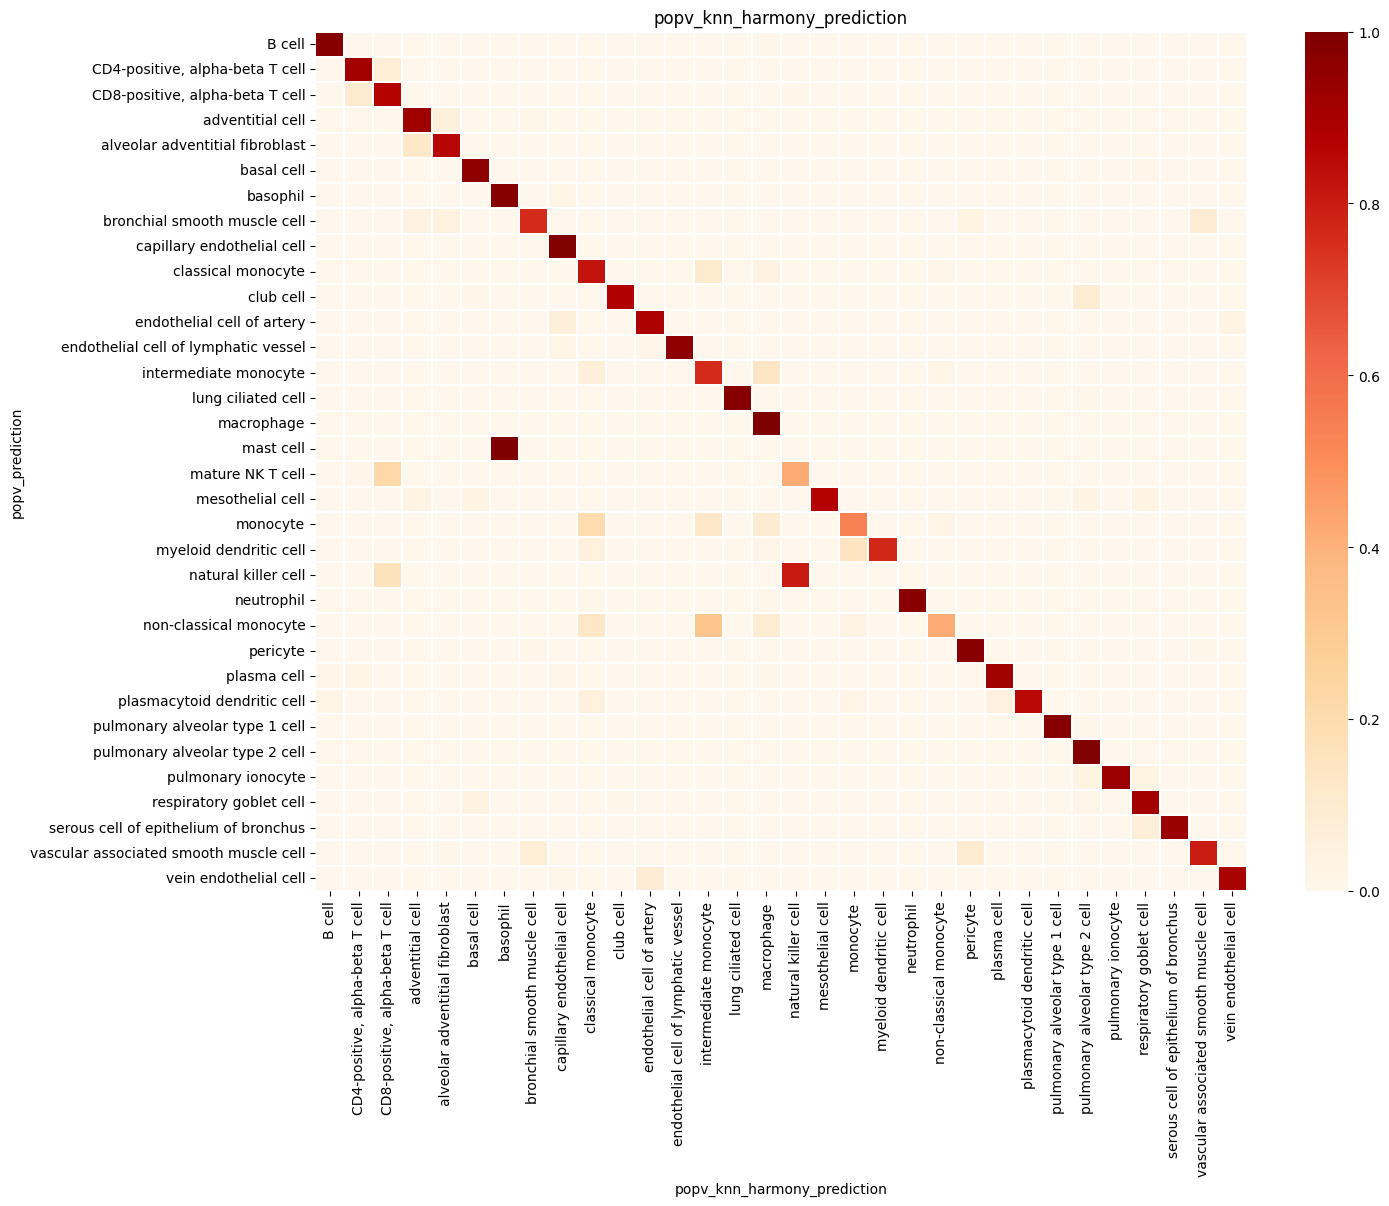

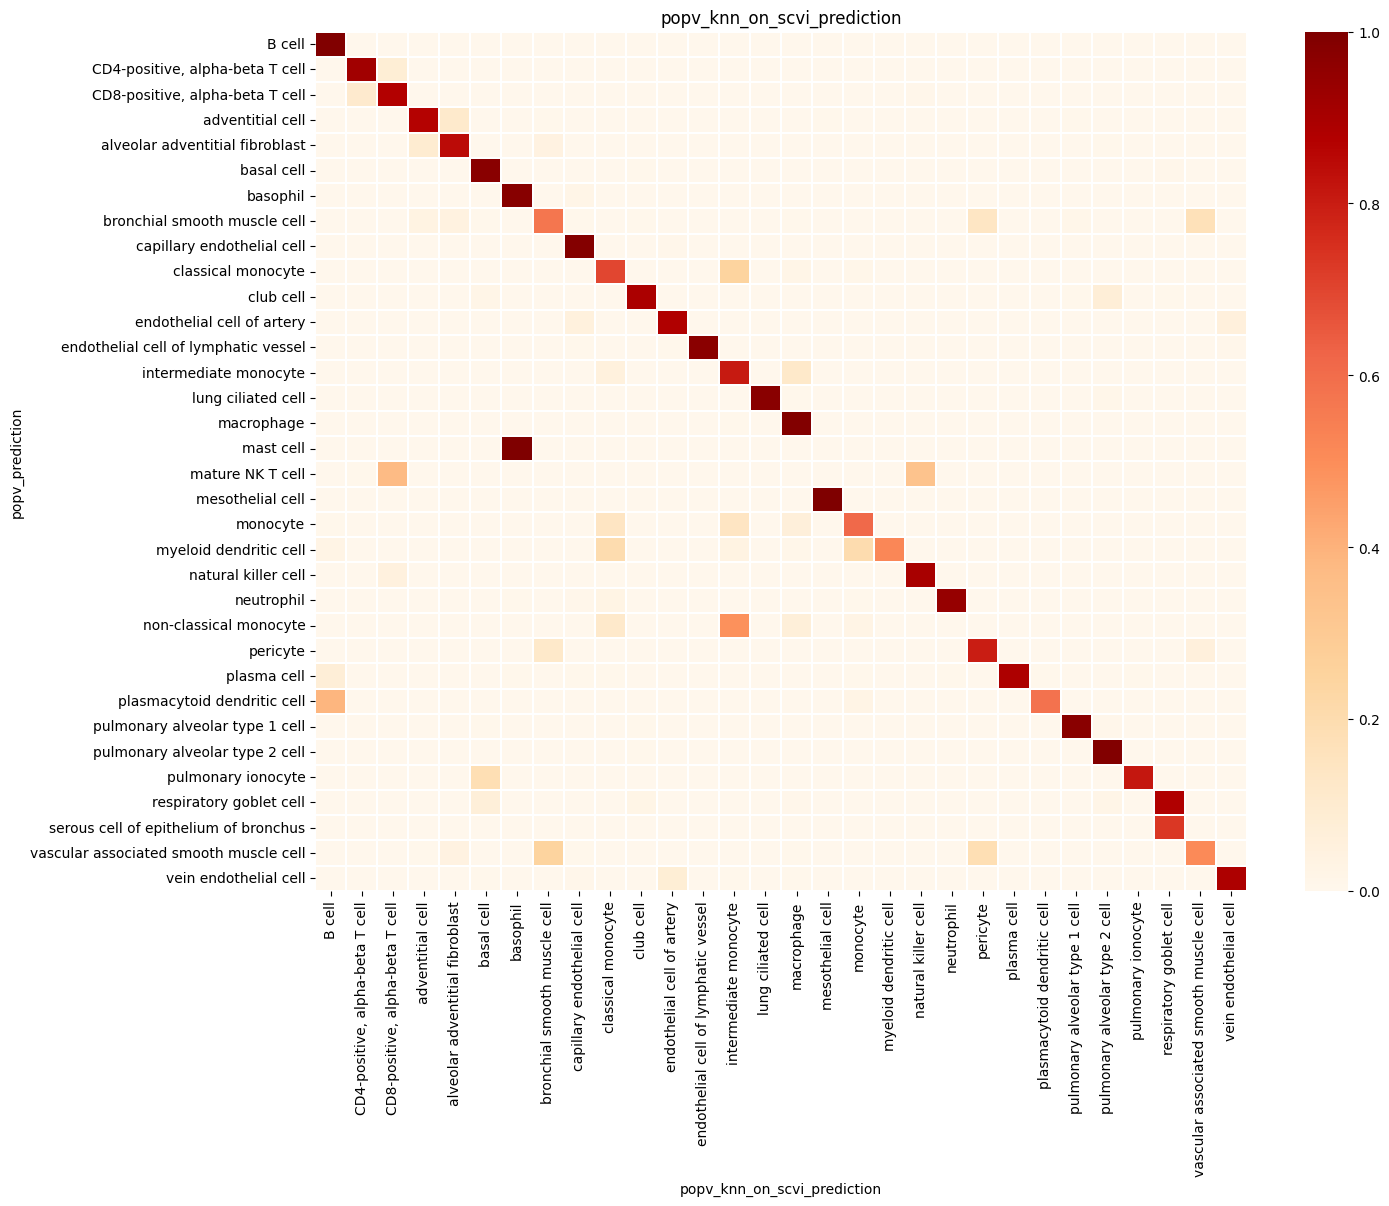

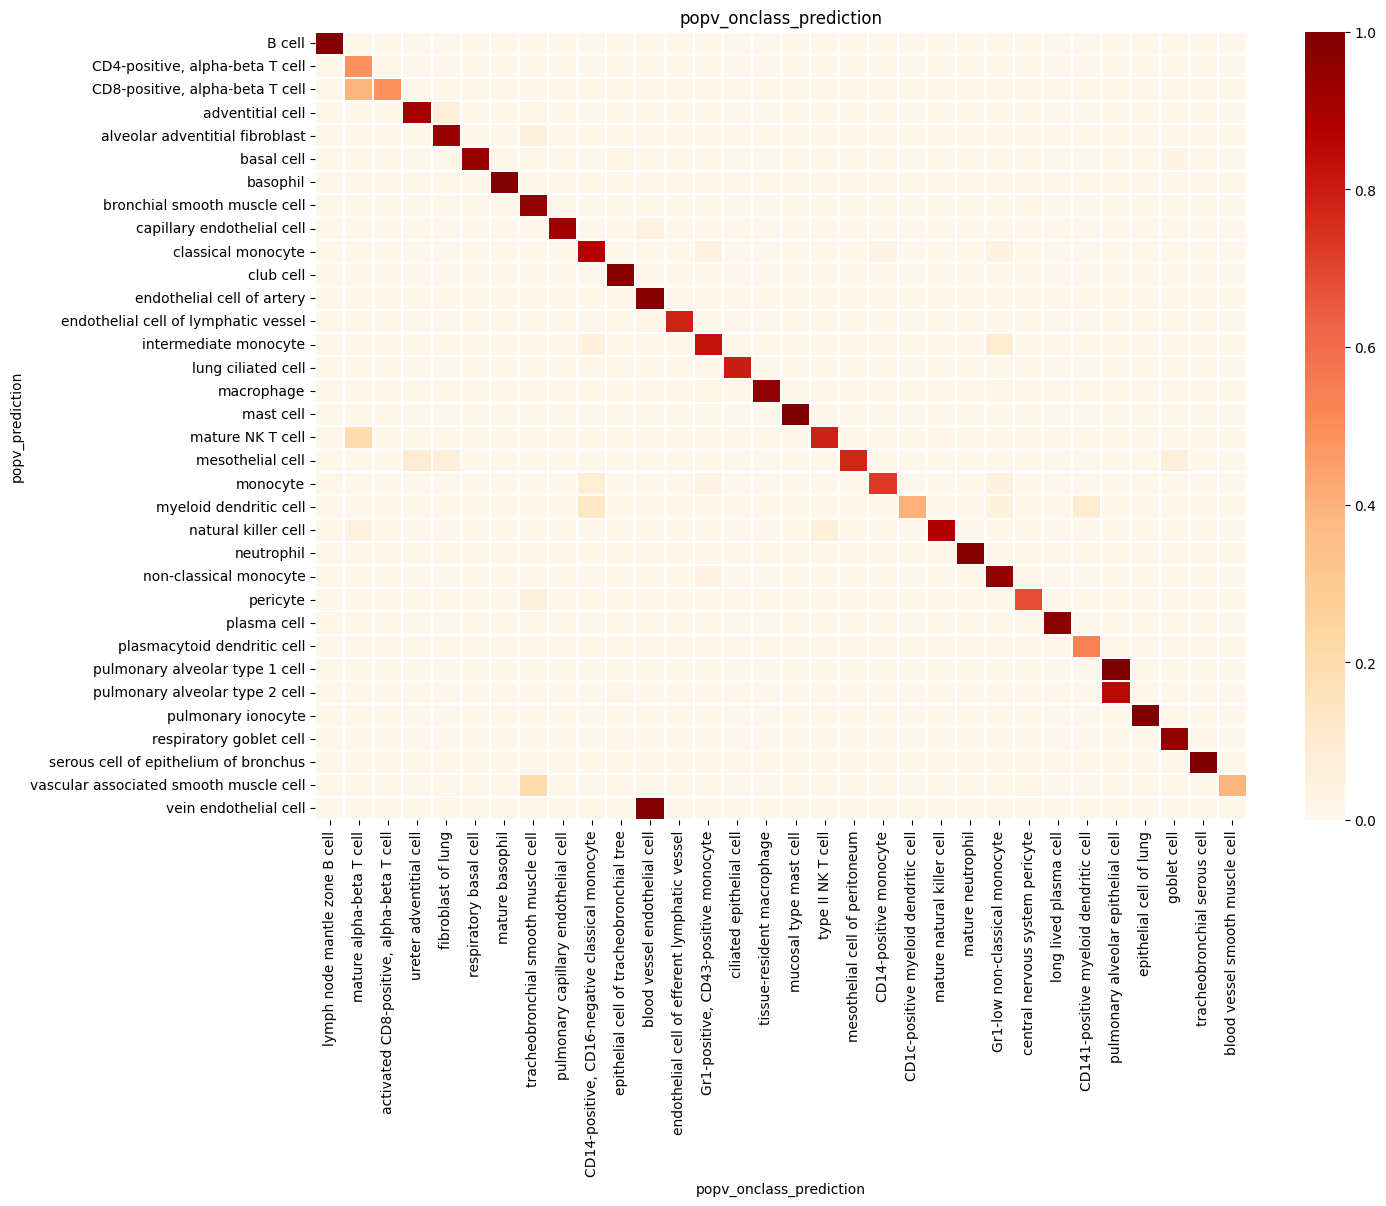

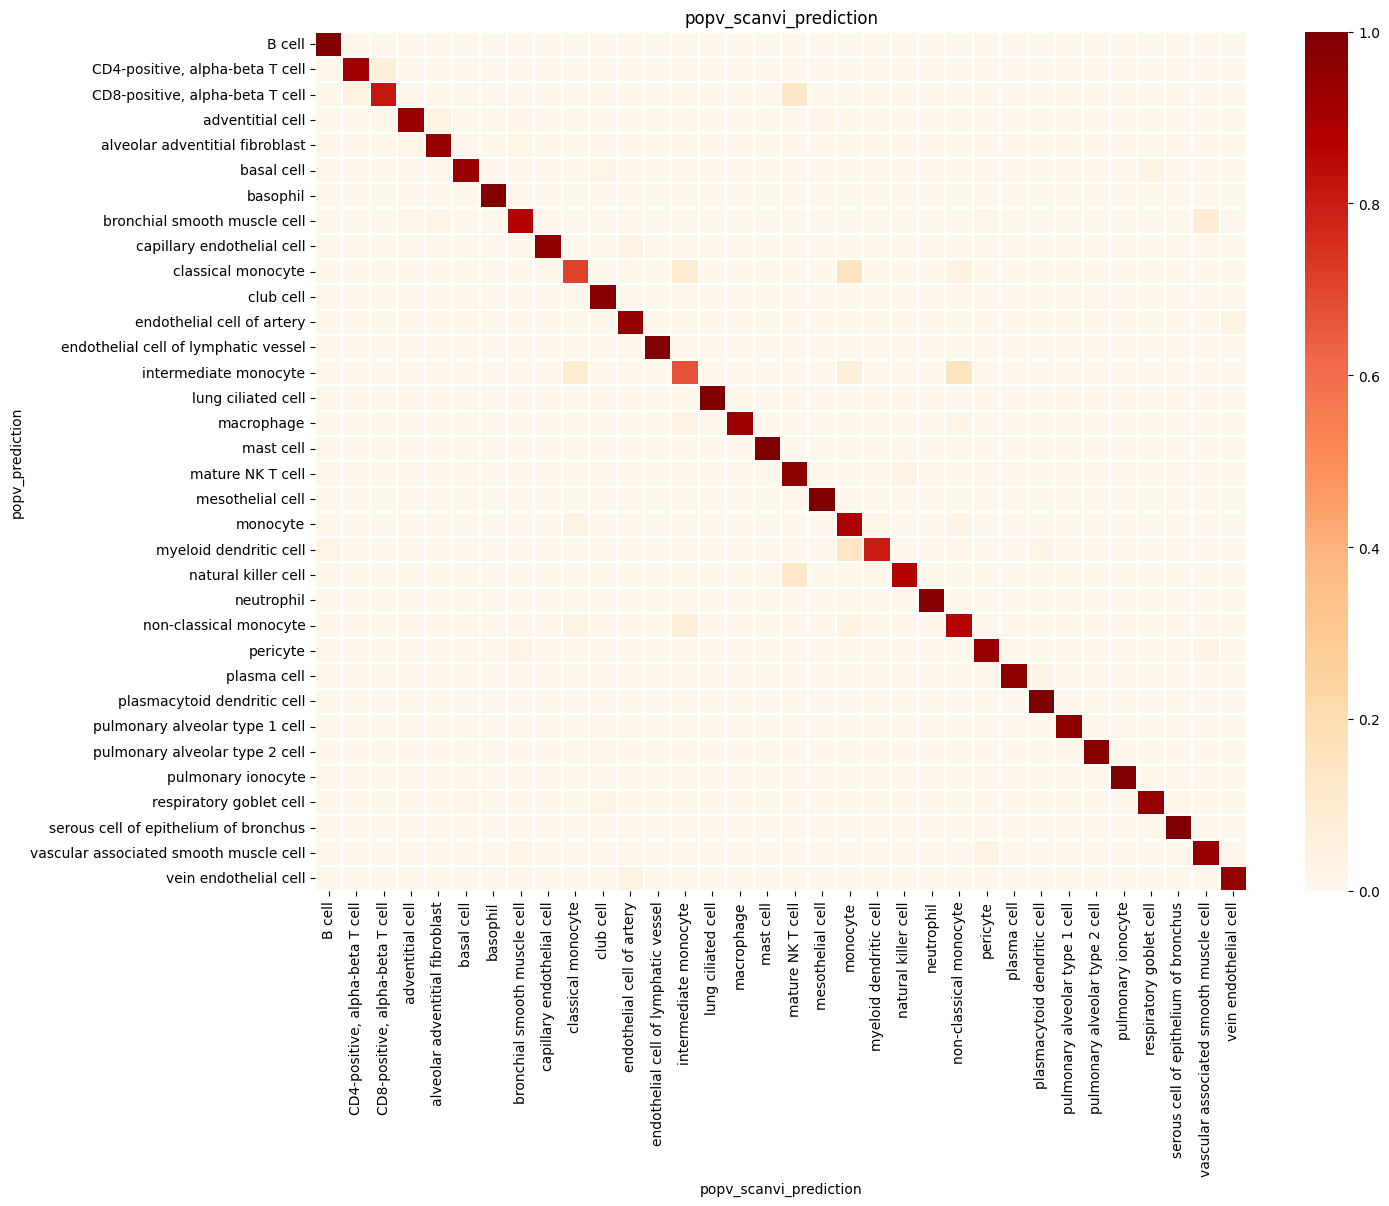

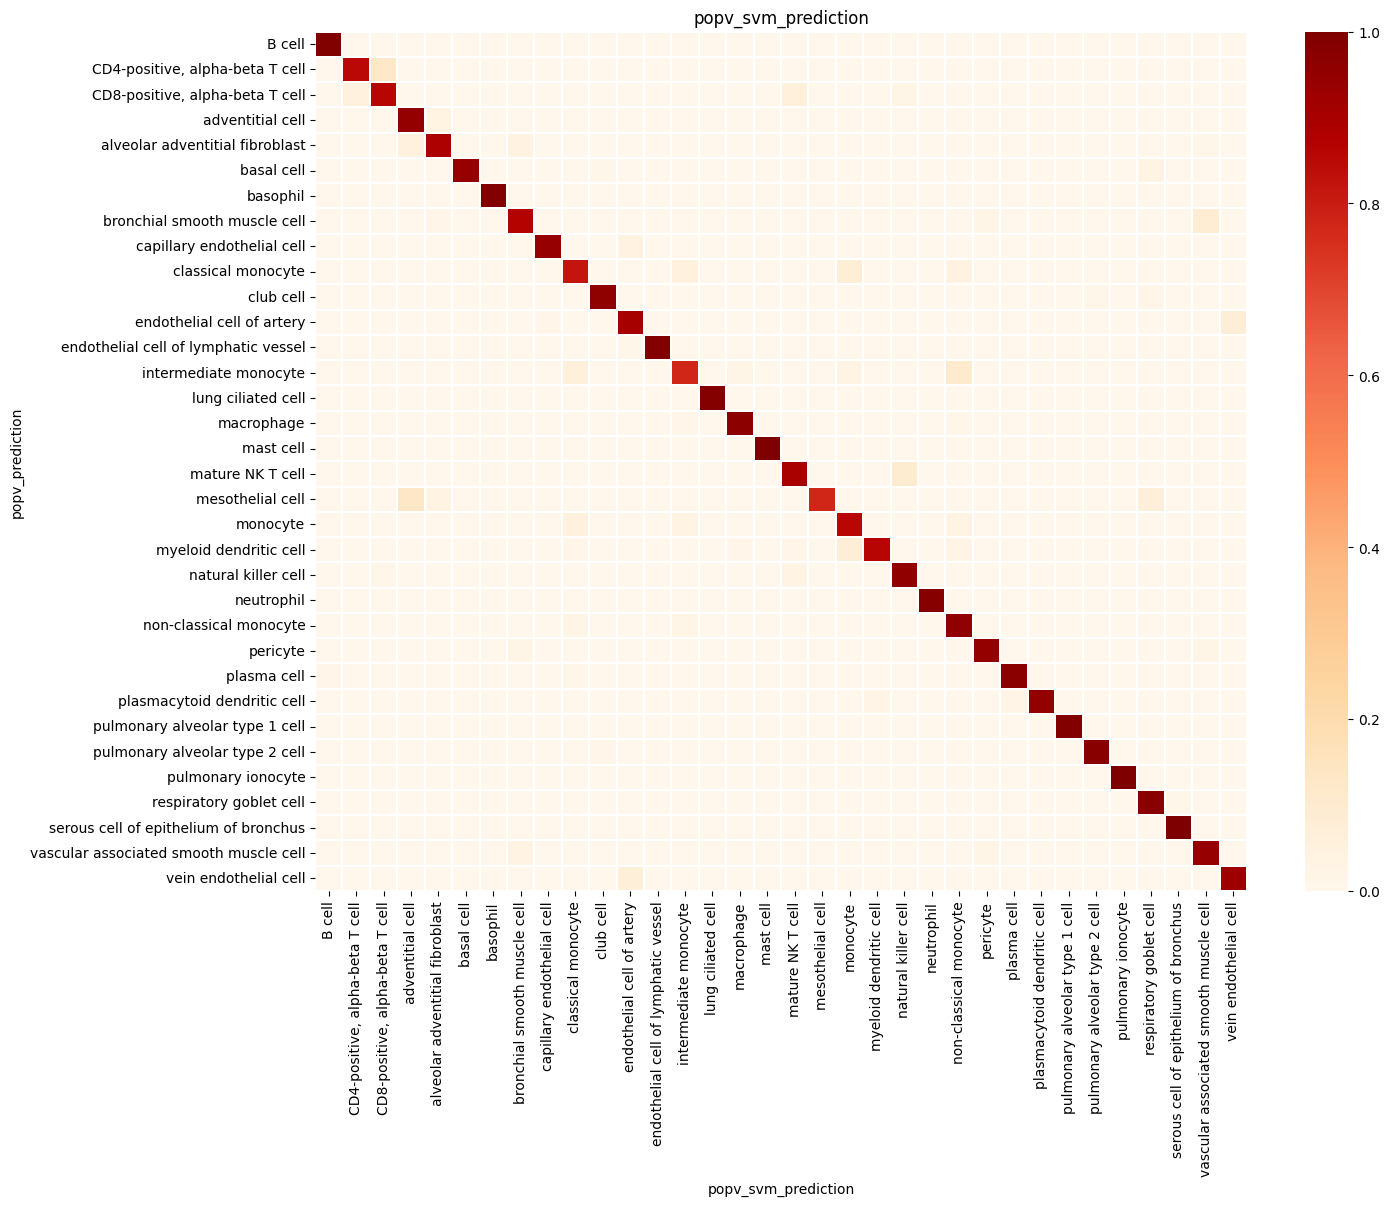

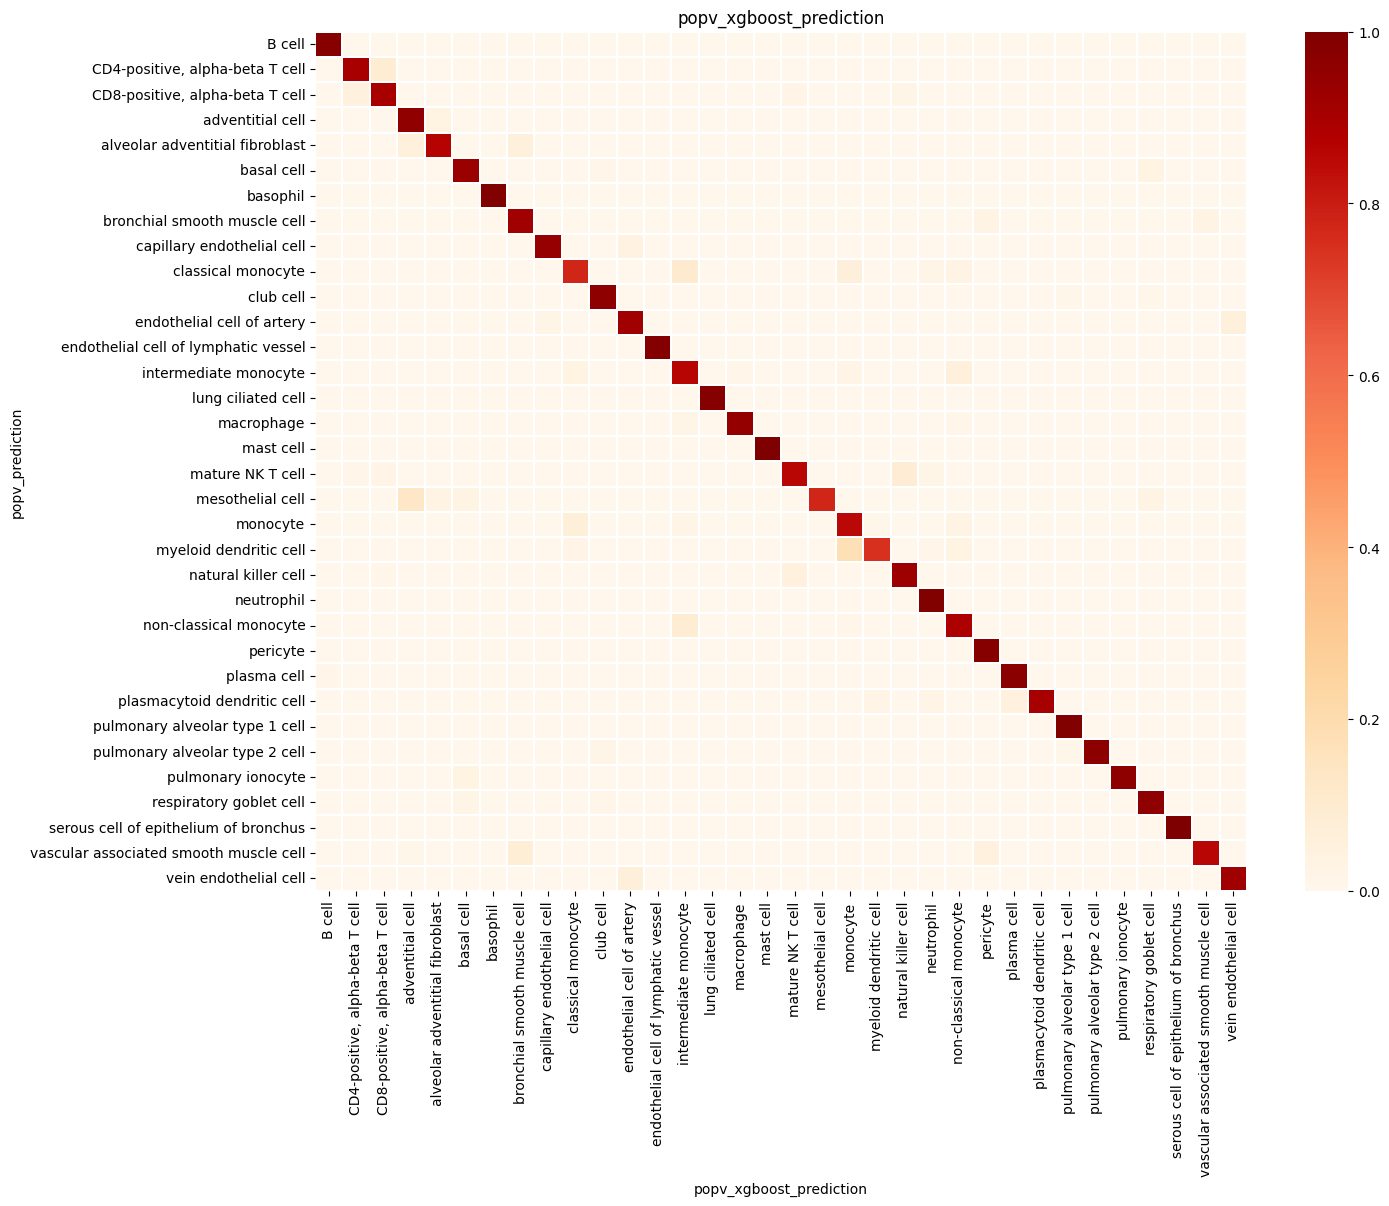

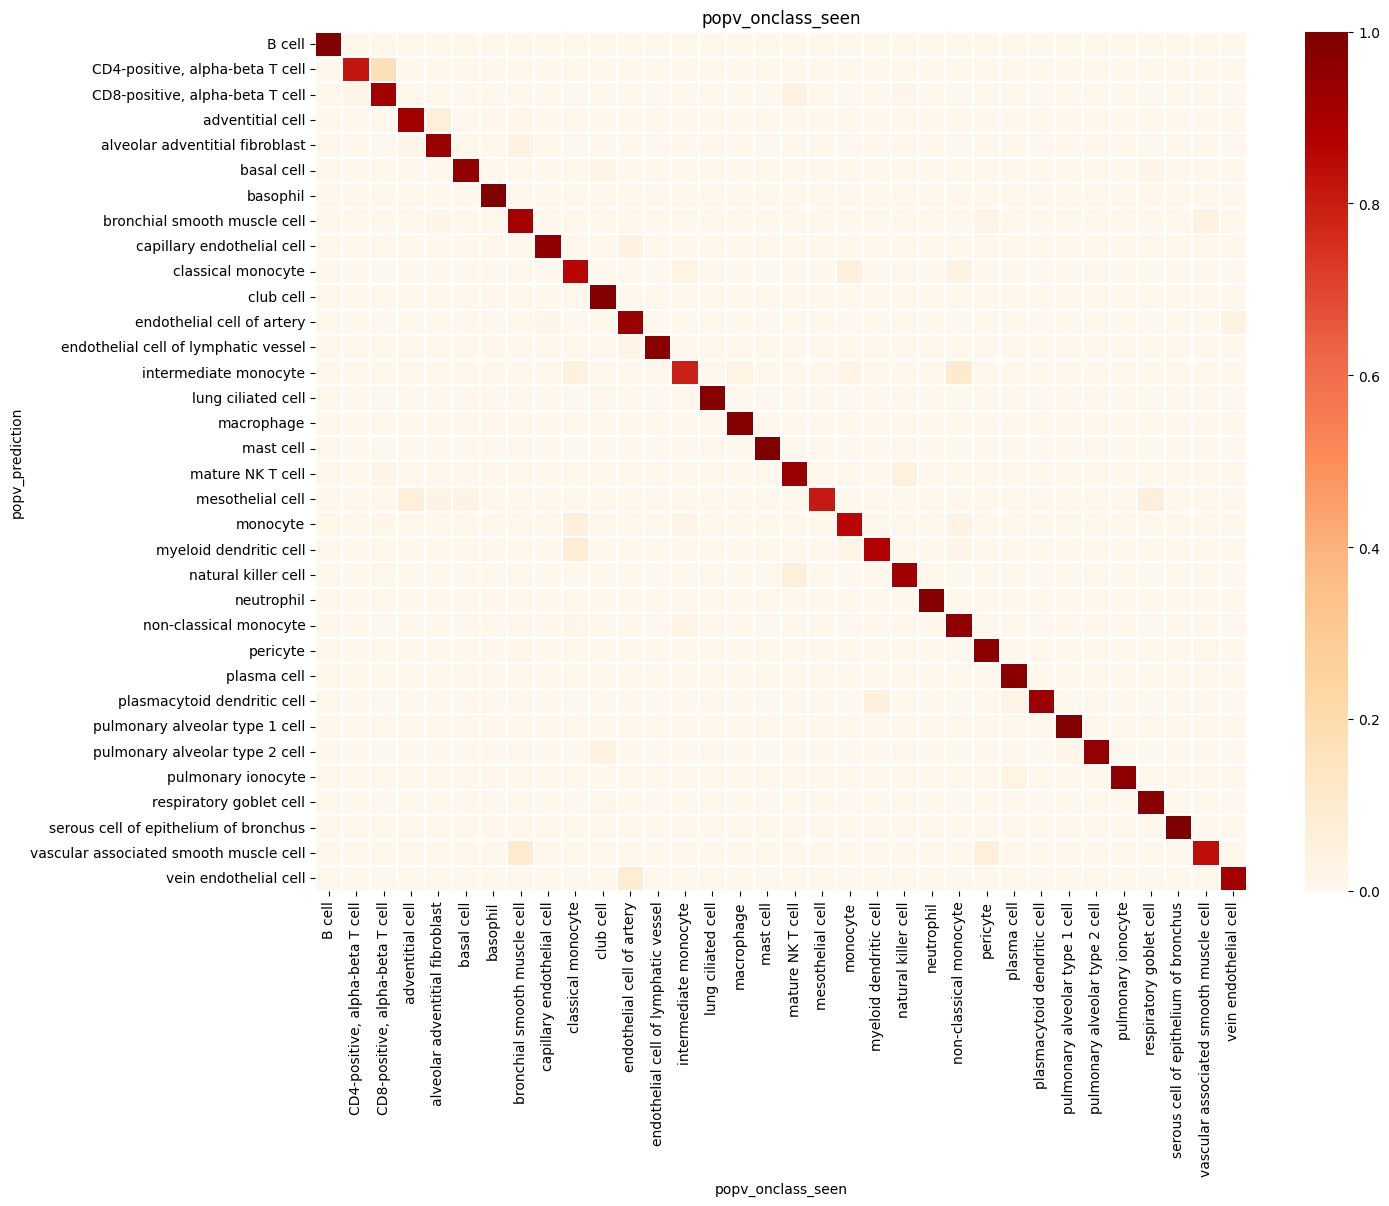

In [ ]:
popv.visualization.make_agreement_plots(
    adata,
    prediction_keys=adata.uns["prediction_keys"] + ["popv_onclass_seen"],
)

<Axes: title={'center': 'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

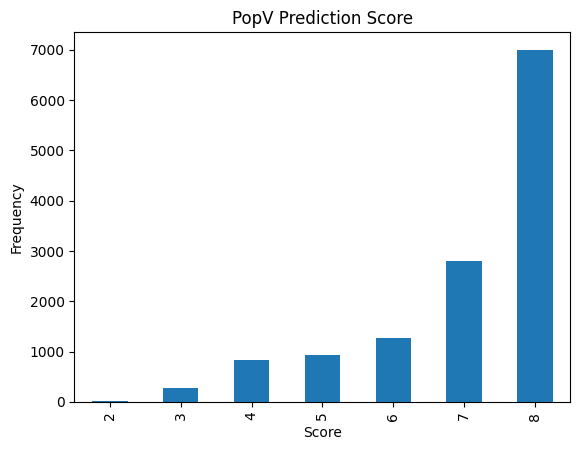

In [ ]:
popv.visualization.prediction_score_bar_plot(adata, popv_prediction_score="popv_prediction_score")

<Axes: ylabel='Mean Agreement'>

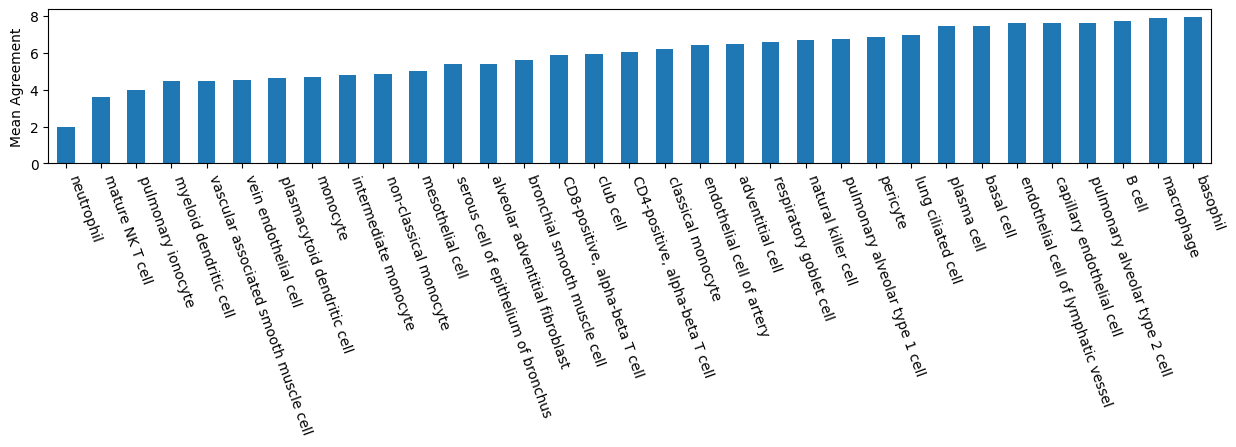

In [ ]:
popv.visualization.agreement_score_bar_plot(adata)

### Cell type proportion plot

<Axes: ylabel='Celltype Abundance'>

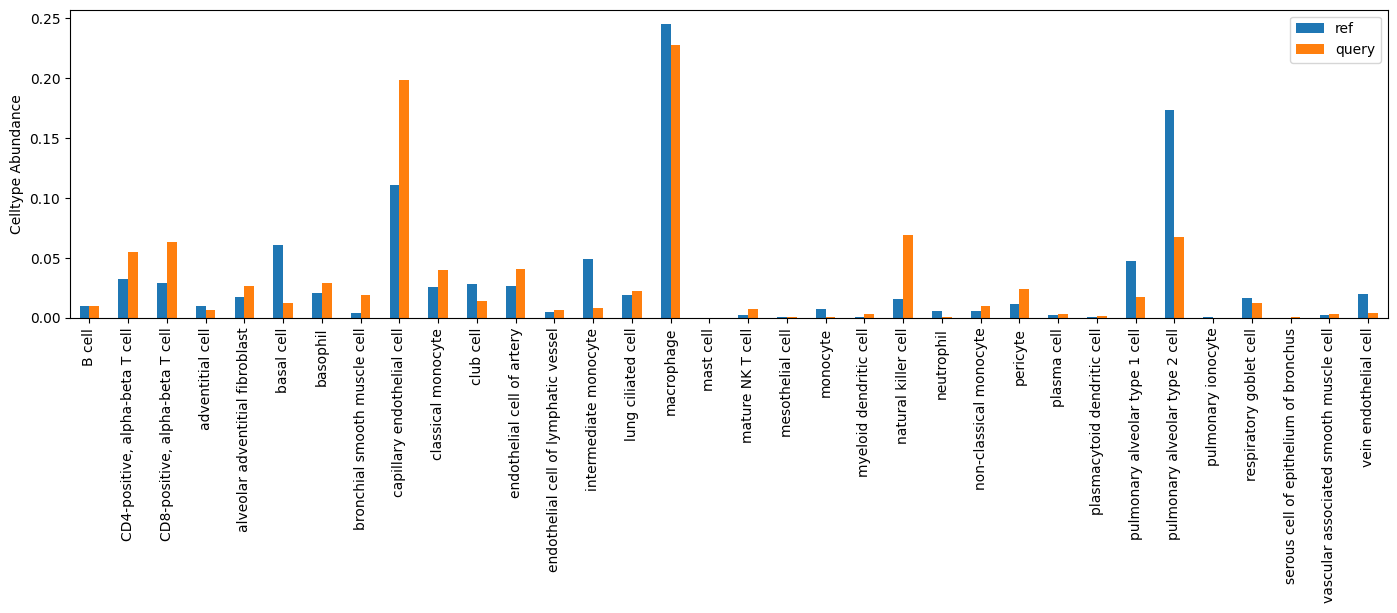

In [ ]:
popv.visualization.celltype_ratio_bar_plot(adata)